# 07g scATAC seq preprocessing MPPs

analysis of scATAC seq in MPPs using Signac

used this docker image

docker run 
--rm 
-d 
--name signac 
-p 8880:8888 
-e JUPYTER_ENABLE_LAB=YES 
-v /Users/efast/Documents/:/home/jovyan/work 
signac_seurat:vs5

In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)
library(ggplot2)
library(JASPAR2018)
library(TFBSTools)
#library(BSgenome.Mmusculus.UCSC.mm10)
library(tidyverse)

set.seed(1234)

Warning message:
“package ‘Seurat’ was built under R version 3.6.2”Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors
Loading req

In [2]:
counts <- Read10X_h5(filename = "./raw_data/ATAC_MPP/filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file = "./raw_data/ATAC_MPP/singlecell.csv",
  header = TRUE,
  row.names = 1
)

MPP <- CreateSeuratObject(
  counts = counts,
  assay = 'peaks',
  project = 'ATAC',
  min.cells = 1,
  meta.data = metadata
)

Warning message in CreateSeuratObject(counts = counts, assay = "peaks", project = "ATAC", :
"Some cells in meta.data not present in provided counts matrix."

In [3]:
fragment.path <- './raw_data/ATAC_MPP/fragments.tsv.gz'

MPP <- SetFragments(
  object = MPP,
  file = fragment.path
)

In [4]:
MPP <- NucleosomeSignal(object = MPP)

Extracting reads in requested region
Computing ratio of mononucleosomal to nucleosome-free fragments


Warning message:
"Removed 3 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 3 rows containing missing values (geom_point)."

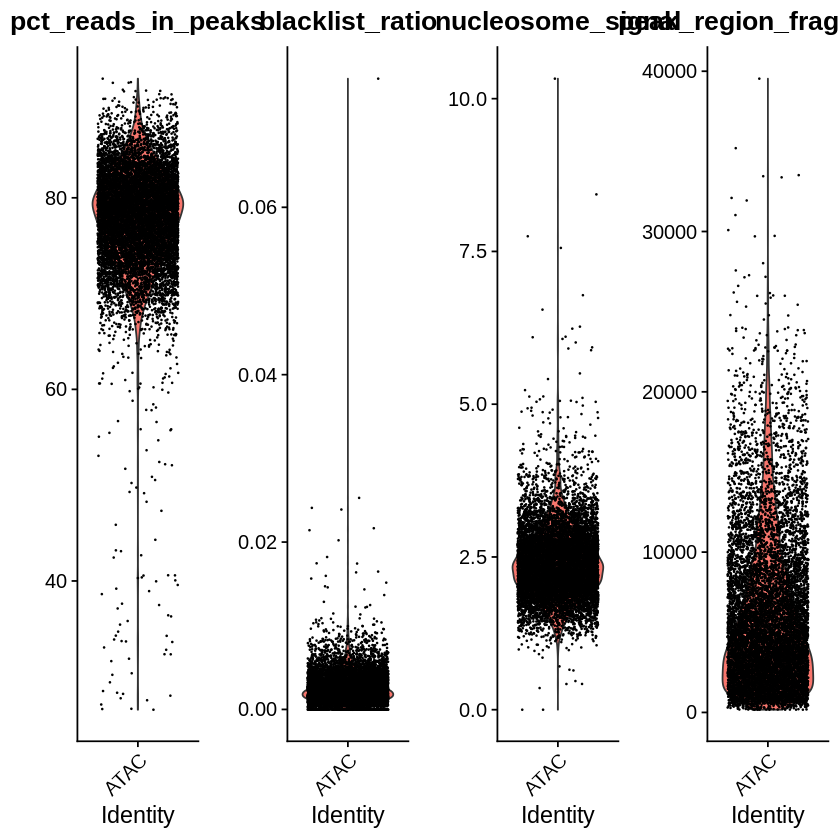

In [5]:
MPP$pct_reads_in_peaks <- MPP$peak_region_fragments / MPP$passed_filters * 100
MPP$blacklist_ratio <- MPP$blacklist_region_fragments / MPP$peak_region_fragments

VlnPlot(
  object = MPP,
  features = c('pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_signal', 'peak_region_fragments'),
  pt.size = 0.1,
  ncol = 4) + NoLegend()

Warning message:
"Removed 205 rows containing non-finite values (stat_bin)."Warning message:
"Removed 4 rows containing missing values (geom_bar)."

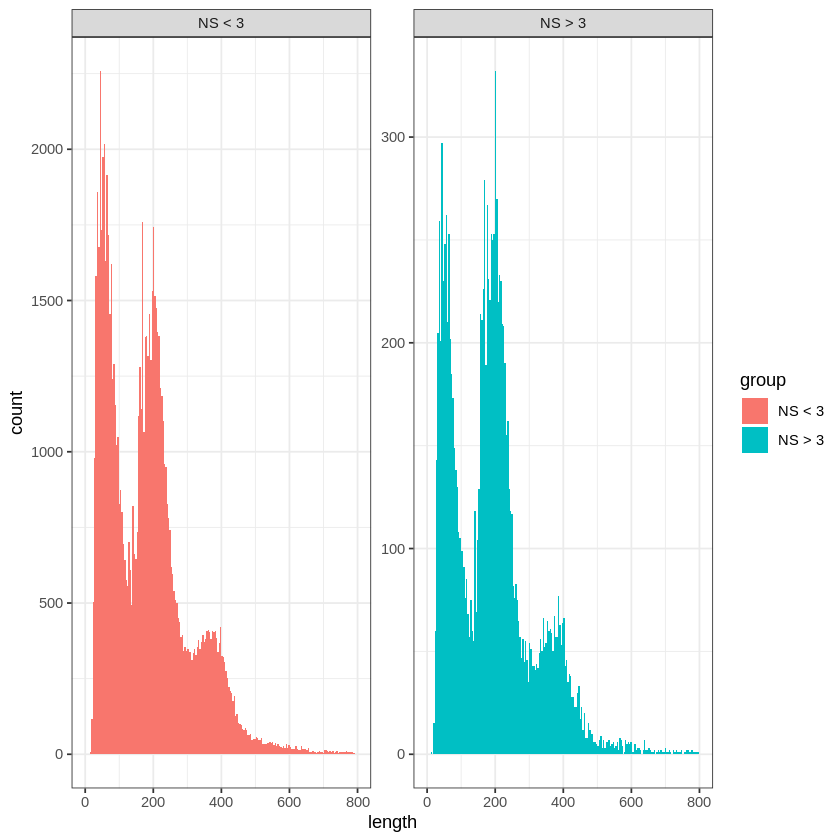

In [6]:
MPP$nucleosome_group <- ifelse(MPP$nucleosome_signal > 3, 'NS > 3', 'NS < 3')
FragmentHistogram(object = MPP, group.by = 'nucleosome_group', region = 'chr1-1-10000000')

In [7]:
# create granges object with TSS positions
gene.ranges <- genes(EnsDb.Mmusculus.v79)
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding', ]

tss.ranges <- GRanges(
  seqnames = seqnames(gene.ranges),
  ranges = IRanges(start = start(gene.ranges), width = 2),
  strand = strand(gene.ranges)
)

seqlevelsStyle(tss.ranges) <- 'UCSC'
tss.ranges <- keepStandardChromosomes(tss.ranges, pruning.mode = 'coarse')

# to save time use the first 2000 TSSs
MPP <- TSSEnrichment(object = MPP, tss.positions = tss.ranges[1:2000])

Finding + strand cut sites
Finding - strand cut sites
Computing mean insertion frequency in flanking regions
Normalizing TSS score


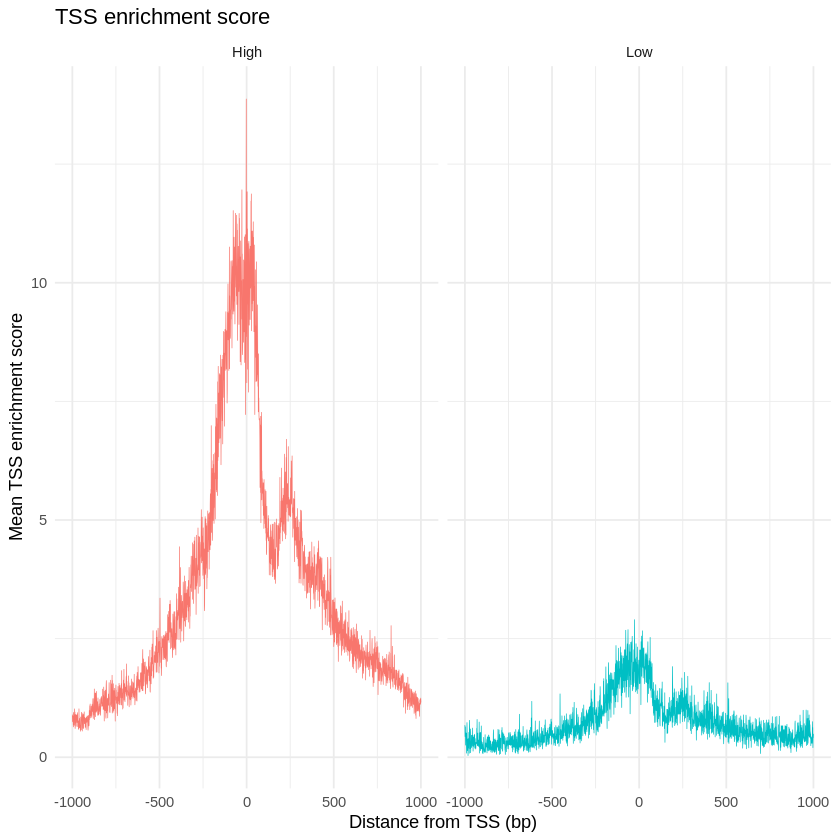

In [8]:
MPP$high.tss <- ifelse(MPP$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(MPP, group.by = 'high.tss') + ggtitle("TSS enrichment score") + NoLegend()

In [9]:
MPP <- subset(MPP, subset = peak_region_fragments > 1000 & peak_region_fragments < 20000 & pct_reads_in_peaks > 60 & blacklist_ratio < 0.02 & nucleosome_signal < 5 & TSS.enrichment > 2)
MPP

An object of class Seurat 
178041 features across 8770 samples within 1 assay 
Active assay: peaks (178041 features)

In [10]:
MPP <- RunTFIDF(MPP)
MPP <- FindTopFeatures(MPP, min.cutoff = 'q0')
MPP <- RunSVD(
  object = MPP,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi'
)

Performing TF-IDF normalization
Running SVD
Scaling cell embeddings


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"00:15:30 UMAP embedding parameters a = 0.9922 b = 1.112
00:15:31 Read 8770 rows and found 30 numeric columns
00:15:31 Using Annoy for neighbor search, n_neighbors = 30
00:15:31 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
00:15:33 Writing NN index file to temp file /tmp/RtmpqW0xdw/file5d321f8a75e
00:15:33 Searching Annoy index using 1 thread, search_k = 3000
00:15:36 Annoy recall = 100%
00:15:39 Commencing smooth kNN distance calibration using 1 thread
00:15:41 Initializing from normalized Laplacian + noise
00:15:41 Commencing optimization

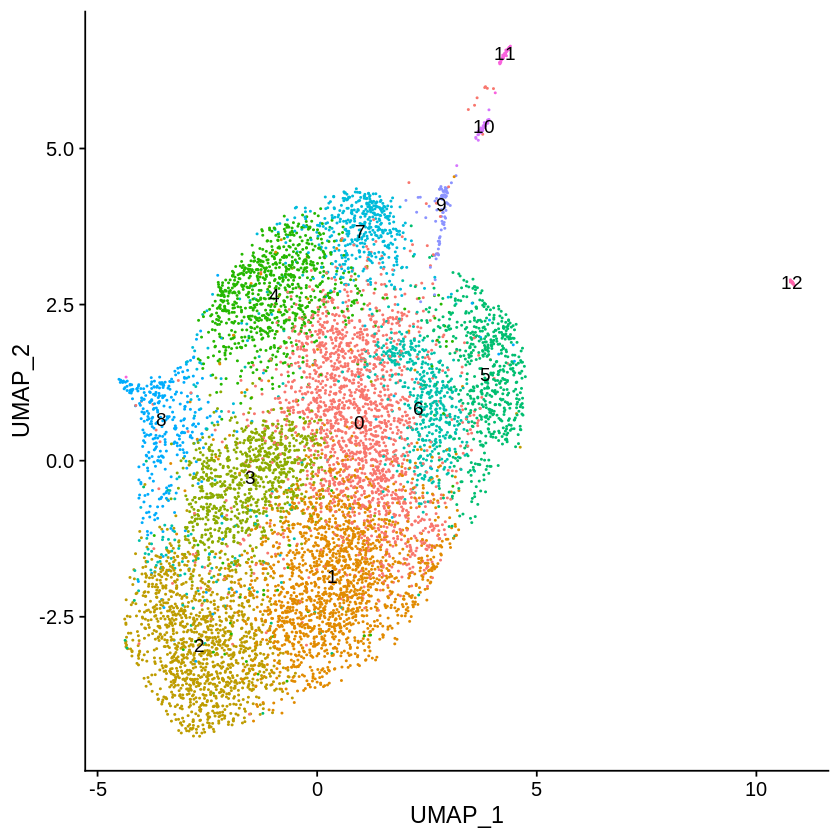

In [11]:
MPP <- RunUMAP(object = MPP, reduction = 'lsi', dims = 1:30)
MPP <- FindNeighbors(object = MPP, reduction = 'lsi', dims = 1:30)
MPP <- FindClusters(object = MPP, verbose = FALSE)
DimPlot(object = MPP, label = TRUE) + NoLegend()

In [12]:
# add information about male cells as metainfomation

counts_df <- GetAssayData(object = MPP, slot = "counts")
male_counts <- colSums(counts_df[178024:178041,])
MPP$male <- male_counts
MPP$male_binary <- MPP$male
MPP$male_binary[MPP$male_binary > 0] <- 1

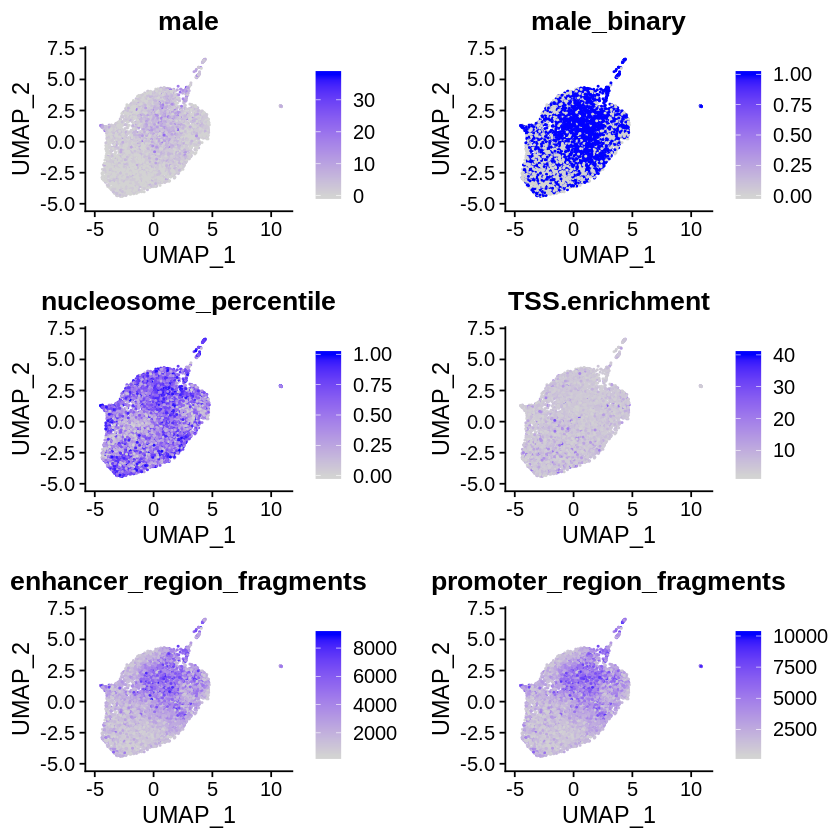

In [13]:
# plot some general stats about cells

FeaturePlot(MPP, features = c("male", 
                               "male_binary", 
                               "nucleosome_percentile", 
                               'TSS.enrichment', 
                               'enhancer_region_fragments',
                               'promoter_region_fragments'
                               ), ncol = 2)

In [14]:
#extract gene coordinates from Ensembl, and ensure name formatting is consistent with  Seurat object 
gene.coords <- genes(EnsDb.Mmusculus.v79, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(gene.coords) <- 'UCSC'
genebody.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')
genebodyandpromoter.coords <- Extend(x = gene.coords, upstream = 2000, downstream = 0)

# build a gene by cell matrix
gene.activities <- FeatureMatrix(
  fragments = fragment.path,
  features = genebodyandpromoter.coords,
  cells = colnames(MPP),
  chunk = 10
)

# convert rownames from chromsomal coordinates into gene names
gene.key <- genebodyandpromoter.coords$gene_name
names(gene.key) <- GRangesToString(grange = genebodyandpromoter.coords)
rownames(gene.activities) <- make.unique(gene.key[rownames(gene.activities)])
gene.activities <- gene.activities[rownames(gene.activities)!="",]

#Add the gene activity matrix to the Seurat object as a new assay, and normalize it
MPP[['RNA']] <- CreateAssayObject(counts = gene.activities)
MPP <- NormalizeData(
  object = MPP,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(MPP$nCount_RNA)
)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 3 out-of-bound ranges located on sequences
  JH584293.1, JH584295.1, and JH584296.1. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information."Extracting reads overlapping genomic regions
Constructing matrix


In [15]:
DefaultAssay(MPP) <- 'RNA'
MPP.markers <- FindAllMarkers(MPP, only.pos = TRUE, min.pct = 0.10, logfc.threshold = 0.20)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12


In [16]:
MPP.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
7.048207e-13,0.2452802,0.646,0.766,1.518043e-08,2,Prdm16
3.792012e-06,0.2376683,0.556,0.694,8.167235e-02,2,Pbx1
1.870224e-03,0.2086044,0.541,0.695,1.000000e+00,2,Gpr56
1.001947e-23,0.2267216,0.736,0.673,2.157994e-19,3,Cables1
2.299851e-18,0.2029443,0.797,0.758,4.953420e-14,3,Smad3
5.821319e-16,0.2054397,0.414,0.326,1.253796e-11,3,Rgs1
7.872203e-22,0.2034776,0.781,0.606,1.695515e-17,5,Angpt1
2.508258e-39,0.2145416,0.597,0.302,5.402286e-35,7,Csmd2
5.330333e-13,0.2638077,0.440,0.298,1.148047e-08,8,Gypc


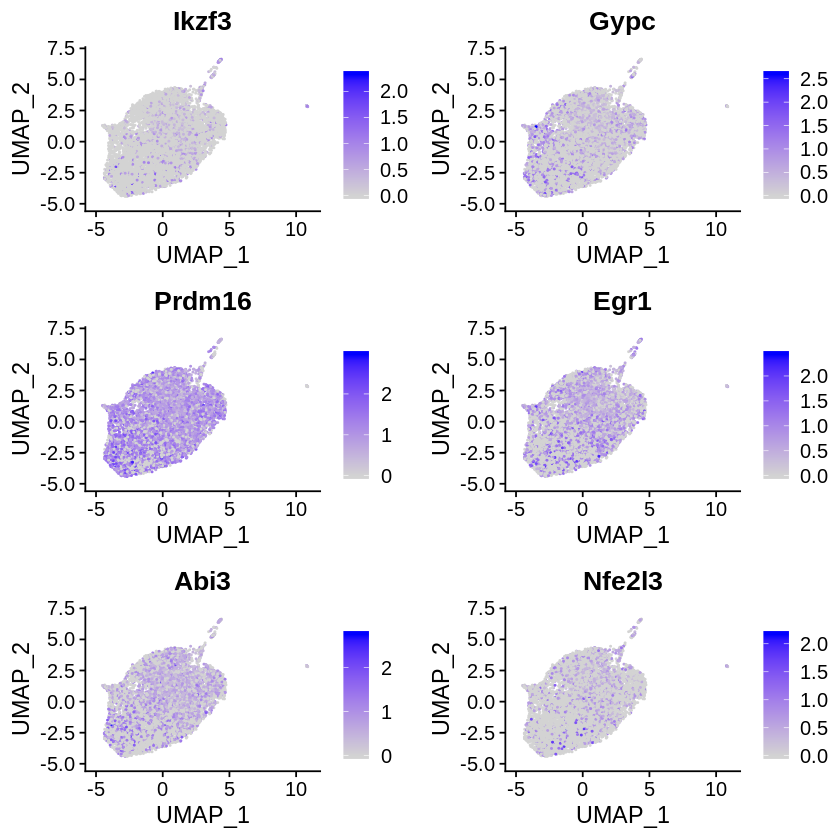

In [17]:
DefaultAssay(MPP) <- 'RNA'
FeaturePlot(
  object = MPP,
  features = c('Ikzf3', 'Gypc', 'Prdm16','Egr1', 'Abi3', 'Nfe2l3'),
  ncol = 2,
)

In [18]:
# find marker peaks

DefaultAssay(MPP) <- 'peaks'
MPP.peaks <- FindAllMarkers(MPP, only.pos = TRUE, min.pct = 0.10, logfc.threshold = 0.20)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12


In [19]:
head(MPP.peaks)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
chr13:56063066-56088404,2.346500e-128,0.2416047,0.501,0.188,4.177733e-123,0,chr13:56063066-56088404
chr8:124924402-124927352,5.934105e-109,0.3388153,0.270,0.075,1.056514e-103,0,chr8:124924402-124927352
chr7:116619940-116621260,2.115656e-99,0.5213051,0.162,0.031,3.766734e-94,0,chr7:116619940-116621260
chr9:47733546-47734789,1.706264e-92,0.4516206,0.173,0.037,3.037850e-87,0,chr9:47733546-47734789
chr4:123024994-123027079,2.849472e-92,0.2546663,0.273,0.084,5.073229e-87,0,chr4:123024994-123027079
chr7:99086229-99087942,1.012780e-89,0.2250013,0.286,0.092,1.803164e-84,0,chr7:99086229-99087942


In [20]:
# annotate all MPP.peaks with closest gene

peaks_all_df <- (MPP.peaks[MPP.peaks$p_val_adj < 0.05, ])
peaks_all <- rownames(peaks_all_df)
closest_all <- ClosestFeature(regions = peaks_all, annotation = EnsDb.Mmusculus.v79, sep = c(':', '-'))
peaks_all_df$query_region <- rownames(peaks_all_df) # makes index to column
peaks_all_df <- merge(peaks_all_df, closest_all, by = 'query_region')



Warning message in if (seqlevelsStyle(x = regions) != seqlevelsStyle(x = annotation)) {:
"the condition has length > 1 and only the first element will be used"

In [21]:
# this is how to extract the genes that are close to the differentially expressed peaks

peaks_0 <- (MPP.peaks %>% filter(avg_logFC > 0.25 & cluster == "0"))$gene
closest_0 <- ClosestFeature(regions = peaks_0, annotation = EnsDb.Mmusculus.v79, sep = c(':', '-'))
head(closest_0)

Warning message in if (seqlevelsStyle(x = regions) != seqlevelsStyle(x = annotation)) {:
"the condition has length > 1 and only the first element will be used"

,gene_id,gene_name,gene_biotype,seq_coord_system,symbol,entrezid,closest_region,query_region,distance
,<chr>,<chr>,<chr>,<chr>,<chr>,<I<named list>>,<chr>,<chr>,<int>
ENSMUSG00000031987,ENSMUSG00000031987,Egln1,protein_coding,chromosome,Egln1,112405,chr8:124908596-124949254,chr8:124924402-124927352,0
ENSMUSG00000030659,ENSMUSG00000030659,Nucb2,protein_coding,chromosome,Nucb2,53322,chr7:116504369-116540554,chr7:116619940-116621260,79385
ENSMUSG00000032076,ENSMUSG00000032076,Cadm1,protein_coding,chromosome,Cadm1,54725,chr9:47530173-47857637,chr9:47733546-47734789,0
ENSMUSG00000028653,ENSMUSG00000028653,Trit1,protein_coding,chromosome,Trit1,66966,chr4:123016597-123054949,chr4:123024994-123027079,0
ENSMUSG00000019843,ENSMUSG00000019843,Fyn,protein_coding,chromosome,Fyn,14360,chr10:39368855-39565381,chr10:39279799-39281393,87461
ENSMUSG00000030199,ENSMUSG00000030199,Etv6,protein_coding,chromosome,Etv6,NA,chr6:134035700-134270158,chr6:134018772-134022427,13272


In [22]:
## save csvs of enrichments

write.csv(MPP.markers,'./write/MPP_markers.csv')
write.csv(peaks_all_df,'./write/MPP_peaks.csv')

In [23]:
### save MMP object

saveRDS(MPP, file = "./sc_objects/scATAC_MPP_processed.rds")

In [24]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] forcats_0.4.0              stringr_1.4.0             
 [3] dplyr_0.8.4                purrr_0.3.3               
 [5] readr_1.3.1                tidyr_1.0.2               
 [7] tibble_2.1.3               tidyverse_1.3.0           
 [9] TFBSTools_1.24.0           JASPAR2018_1.1.1          
[11] g

In [25]:
str(MPP)

Formal class 'Seurat' [package "Seurat"] with 12 slots
  ..@ assays      :List of 2
  .. ..$ peaks:Formal class 'Assay' [package "Seurat"] with 8 slots
  .. .. .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:47725817] 52 130 310 319 896 990 1158 1223 1258 1433 ...
  .. .. .. .. .. ..@ p       : int [1:8771] 0 1323 4939 7918 13388 15460 19213 23723 25268 37278 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 178041 8770
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:178041] "chr1:3445834-3446308" "chr1:3670490-3672736" "chr1:3993177-3993784" "chr1:4228165-4228537" ...
  .. .. .. .. .. .. ..$ : chr [1:8770] "AAACGAAAGAACGCCA-1" "AAACGAAAGCTAGCAG-1" "AAACGAAAGGTCGTTT-1" "AAACGAAAGTTGACAA-1" ...
  .. .. .. .. .. ..@ x       : num [1:47725817] 2 2 2 2 2 2 2 2 1 2 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ data         :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. ..